# Transform Consistency Loss

In [1]:
import pathlib
import tempfile

import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import roma
import tqdm

from Unet2 import UNet
from se3 import se3_log_map, se3_exp_map

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

A few things to fix:
- Understanding the paper
- Loading the data
- Converting the handedness
- Converting between different extrinsic formats and choosing great names for them
- Understanding the sources of NaN - perspective division and taking a log of a negative number

How I was able to do all of these things in 1/2 a day:
- Writing lots of little tests

## Extrinsic Representations

We need to work in at least 3 representations of extrinsic matrices for this problem.

1. Rigid body transforms in $SE(3)$ tangent space are represented as a `transform` matrix
2. Rotation matrices in $SO(3)$ tangent space translation vectors are represented as a `pose` tuple
3. The 6 degrees of freedom are represented as a vector of `params`

These are all isomorphisms, and below we define functions for converting between these different representations.

In [2]:
def transform_from_params(params):
    return se3_exp_map(params).mT

In [3]:
def params_from_transform(transform):
    return se3_log_map(transform.mT)

In [4]:
def pose_from_transform(transform):
    return transform[..., :3, :3], transform[..., :3,[3]]

## Data Loader

A good dataloader should read files from the disk and not use too much memory.

Unfortunately, the large dataset that Oli supplied is compressed in `npz` format, and must be uncompressed first before it can be used. Our strategy will be to load the file, then write it out as a temporary `memmap`'d file which can be indexed without needing to read the whole file into memory.

## Perspective Geometry

In [5]:
def perspective(points, epsilon=1e-8):
    """
    Perspective division
    """
    return points[..., :-1, :] / (points[..., [-1], :] + epsilon)

In [50]:
def apply_transform(points, transform):
    """
    Project points to camera reference frame
    """
    R, t = transform[..., :3, :3], transform[..., :3, [3]]
    return R @ points + t
    # temp_points = torch.cat([points, torch.ones_like(points[..., [0]])], dim=-2)
    # return (transform @ points)[:,:3,:]

In [51]:
def project(points, K, height, width):
    """
    Project 3D points into a 2D image with intrinsic matrix K
    """
    coords = K @ points
    coords = perspective(coords)
    coords = coords.view(-1, height, width, 2)
    coords = (coords - 0.5) * 2
    return coords

In [52]:
def backproject(depth, K):
    """
    Backproject a depth map into 3D space with normalized intrinsic matrix K.
    The depth map should be normalized between (min_depth, max_depth).
    """
    height, width = depth.shape[-2:]
    size = height * width
    y = torch.linspace(0, 1, height, device=depth.device, dtype=depth.dtype)
    x = torch.linspace(0, 1, width,  device=depth.device, dtype=depth.dtype)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=depth.device)
    points = torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)
    points = torch.linalg.inv(K) @ points
    return points * depth.view(-1, size, 1, 1)

In [53]:
def pix_coords(height, width, device):
    """
    Create a grid of camera pixels in normalized device coordinates
    """
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)

In [54]:
def warp(homography, image, padding_mode="border"):
    """
    Warp an image using homography
    """
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=device)
    warped = project(homography @ coords, height, width)
    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    return warped

In [55]:
def reproject(depth, image, K, transform):
    """
    Backproject a depth map and transform it into the reference frame of a new camera
    defined by K, R, t by resampling the image.
    """
    points_3d = backproject(depth, K)
    points_3d = apply_transform(points_3d, transform)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    output = F.grid_sample(image, points_2d, padding_mode="zeros", align_corners=False)
    return output

### Testing Perspective Geometry

Let's see if we can project image_0 into image_1.

## Gauss-Newton

In [56]:
def gauss_newton(x, residuals, damping=1., iterations=5):
    # Unroll a number of iterations of Gauss-Newton.
    for i in range(0, iterations):
        # Compute the gauss-newton updates.
        R = residuals(x)
        # We need nan_to_num in case there are no errors..!
        J = torch.autograd.functional.jacobian(residuals, x)
        # https://en.wikipedia.org/wiki/Gauss–Newton_algorithm
        J = (j.sum(0, keepdim=True) for j in J)
        R = (-torch.atleast_1d(r) for r in R)
        # J.mT @ J, J.mT @ r
        u = torch.stack([
            torch.linalg.lstsq(j, -r).solution
            for j, r in zip(J, R)
        ])
        # Update x, but do nothing if the solution is bad
        x = x + damping * u.nan_to_num(0)  # continue iterating
        # if J.sum() ==0:
        #     print("jacobian is 0", "\n x", x, "\nr", r, "\nJ", J)
    return x

In [57]:
def align_feature_maps(K, features_q, saliency_q, features_r, saliency_r, depth_r, delta):
    def residuals(params):
        transform = transform_from_params(params).unsqueeze(1)
        features_estimated = reproject(depth_r, features_r, K, transform)
        saliency_estimated = reproject(depth_r, saliency_r, K, transform)
        errors = torch.nn.functional.huber_loss(features_q, features_estimated, reduction='none', delta=delta)
        errors = saliency_estimated * saliency_q * errors
        return tuple(error.sum() for error in errors)
    return residuals

In [58]:
def align_images(K, image_q, image_r, depth_r):
    def residuals(params):
        transform = transform_from_params(params).unsqueeze(1)
        image_est = reproject(depth_r, image_r, K, transform)
        errors = torch.nn.functional.huber_loss(image_q, image_est, reduction='none', delta=0.2)
        return tuple(error.sum() for error in errors)
    return residuals

In [59]:
#generate a feature map and corresponding depth map, pose.
# project the feature map to another view
# use Gauss newton to optimize the relative pose
# compare the optimized pose with the ground truth

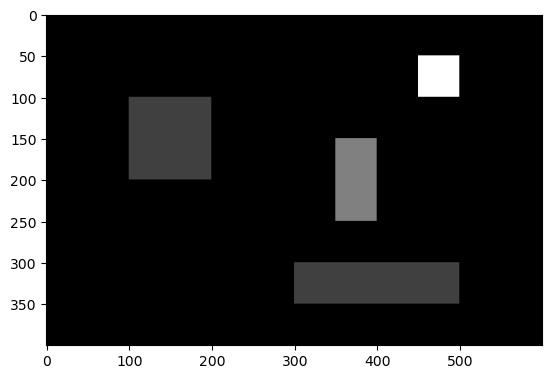

In [60]:
#generate a feature map and corresponding depth map, pose.
import cv2
import numpy as np
image_0 = np.zeros((400,600,3), dtype=np.uint8)
# draw 4 rectangles, further ones having smaller size
cv2.rectangle(image_0, (100, 100), (200, 200), (255,255,255), -1) # surface area = 10000
cv2.rectangle(image_0, (450, 50), (500, 100), (255,255,255), -1) # surface area = 2500 
cv2.rectangle(image_0, (300, 300), (500, 350), (255,255,255), -1) #10000
cv2.rectangle(image_0, (350, 150), (400, 250), (255,255,255), -1) #5000
# plt.imshow(image_0)
# depth is linearly relative to surface area
depth_0 = np.zeros((400,600), dtype=np.float32)
depth_0[100:200, 100:200] = 1/10
depth_0[50:100, 450:500] = 1/2.5
depth_0[300:350, 300:500] = 1/10
depth_0[150:250, 350:400] = 1/5
plt.imshow(depth_0, cmap='gray')
image_0_tensor = torch.from_numpy(image_0).permute(2,0,1).unsqueeze(0).float().to(device)/255
depth_0_tensor = torch.from_numpy(depth_0).unsqueeze(0).float().to(device)*1000

In [75]:
K = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=torch.float32, device=device)
extrinsic0 = torch.tensor([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]], dtype=torch.float32, device=device)
# set up a transformation between 0 to 1
gt_T01 = roma.rotvec_to_rotmat(torch.tensor([0.0,0.0,0], dtype=torch.float32, device=device))
gt_T01 = torch.cat([gt_T01, torch.tensor([[0,5,0]], dtype=torch.float32, device=device).T], dim=1)
gt_T01 = torch.cat([gt_T01, torch.tensor([[0,0,0,1]], dtype=torch.float32, device=device)], dim=0)

In [76]:
gt_T01

tensor([[1., -0., 0., 0.],
        [0., 1., -0., 5.],
        [-0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0')

In [77]:
# find the depth map and feature map of the second image
image_1 = reproject(depth_0_tensor, image_0_tensor, K, gt_T01)
# find the depth map of the second image
# backproject the depth map to 3d points in image 0
image_depth = depth_0_tensor.unsqueeze(0)
image_1_depth = reproject(depth_0_tensor, image_depth, K, gt_T01)
depth_1 = image_1_depth.squeeze(0)

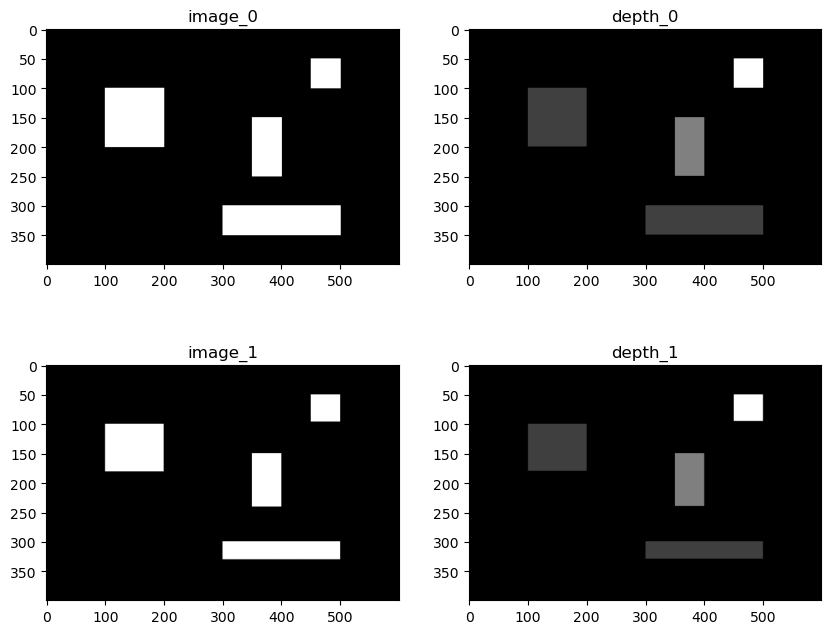

In [78]:
# plt image_0, depth_0, image_1, depth_1
fig,ax = plt.subplots(2,2, figsize=(10,8))
ax[0,0].set_title('image_0')
ax[0,1].set_title('depth_0')
ax[1,0].set_title('image_1')
ax[1,1].set_title('depth_1')
ax[0,0].imshow(image_0_tensor.squeeze(0).permute(1,2,0).cpu().numpy())
ax[0,1].imshow(depth_0_tensor.squeeze().cpu().numpy(), cmap='gray')
ax[1,0].imshow(image_1.squeeze(0).permute(1,2,0).cpu().numpy())
ax[1,1].imshow(depth_1.squeeze().cpu().numpy(), cmap='gray')

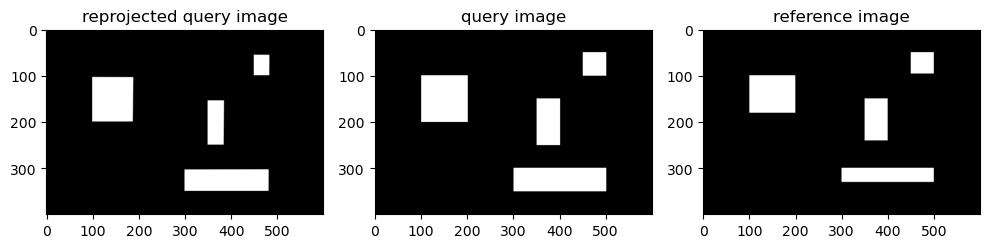

In [79]:
guess = torch.zeros(1, 6).to(device)

residual = align_images(K.unsqueeze(0).unsqueeze(0), image_0_tensor, image_1, depth_1)
estimate = gauss_newton(guess, residual, damping=0.01, iterations=50)
image_01 = reproject(depth_0_tensor, image_0_tensor, K, transform_from_params(estimate).unsqueeze(1))
fig, axs = plt.subplots(1,3, figsize=(10, 8))

axs[0].set_title('reprojected query image')
axs[1].set_title('query image')
axs[2].set_title('reference image')

axs[0].imshow(image_01[0].cpu().permute(1,2,0))
axs[1].imshow(image_0_tensor [0].cpu().permute(1,2,0))
axs[2].imshow(image_1 [0].cpu().permute(1,2,0))
plt.tight_layout()
plt.show()

In [21]:
transform_from_params(estimate), gt_T01

(tensor([[[ 9.9985e-01, -2.7934e-03,  1.7301e-02, -6.5755e-06],
          [ 2.4410e-03,  9.9979e-01,  2.0357e-02, -1.0292e-04],
          [-1.7354e-02, -2.0311e-02,  9.9964e-01,  7.6307e-05],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
        device='cuda:0'),
 tensor([[ 9.9995e-01,  2.4995e-04,  9.9957e-03,  0.0000e+00],
         [ 2.4995e-04,  9.9875e-01, -4.9978e-02,  0.0000e+00],
         [-9.9957e-03,  4.9978e-02,  9.9870e-01,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0'))